# Imports and setup.

In [30]:
import logging

import matplotlib.pyplot as plt
import numpy as np

import algorithms
import loss_functions

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.style.use('ggplot')
l_alpha = [0.8, 0.7, 0.6, 0.5, 0.4]
l_alpha = [1, 1, 1, 1, 1]

logging.basicConfig(
    format = '%(asctime)s %(filename)s:%(lineno)d %(message)s',
    datefmt = '%I:%M:%S %p',
    level = logging.INFO
)

rng = np.random.default_rng()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set problem parameters.

In [31]:
m = 10
T = 200

# Create loss functions.

In [32]:
l_fn = loss_functions.average_of_past_decisions_with_rademacher_signs(T, m)
l_fn = loss_functions.square_diff_around_fixed_point(T, m)

# Find the benchmark.

In [33]:
opt = algorithms.optimal_benchmark(
    l_fn,
    rng.random(size = 1),
    T,
    m
)
cum_loss_opt = np.cumsum([l_fn[t]([opt.x] * m) for t in range(T)])

10:42:47 AM algorithms.py:24 Optimal benchmark.
10:42:47 AM algorithms.py:33 	x: [0.3]
10:42:47 AM algorithms.py:34 	success: True
10:42:47 AM algorithms.py:35 	message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
10:42:47 AM algorithms.py:36 	fun: 4.999996830601338e-14


# FTRL.

In [34]:
l_ftrl_res, l_cum_loss_alg = [], []

for mode in algorithms.mode_strs:

    init_fn = getattr(algorithms, f'ftrl_init_{mode}')
    z_0 = init_fn(m)

    eta = None
    eta = 1 / np.sqrt(T)

    if mode == 0 or mode == 1:
        eta /= m**(1/2)
    elif mode == 2 or mode == 3 or mode == 4:
        eta /= m**(3/4)

    l_ftrl_res.append(algorithms.ftrl(
        l_fn,
        z_0,
        T,
        m,
        eta,
        mode
    ))

    cum_loss_alg = np.cumsum([res.l for res in l_ftrl_res[-1]])
    l_cum_loss_alg.append(cum_loss_alg)

10:42:47 AM algorithms.py:61 mode 0: FTRL on f_t and project by taking the average.
10:42:51 AM algorithms.py:61 mode 1: FTRL on f_t and project onto the most recent decision.
10:42:53 AM algorithms.py:61 mode 2: FTRL on \circfn f_t.
10:42:56 AM algorithms.py:61 mode 3: FTRL on f_{1:t}((x, x_{t-1}, \dots, x_{t-m+1})).
10:42:57 AM algorithms.py:61 mode 4: FTRL on \circfn f_t plus \| (x, \dots, x) - (x, x_{t-1}, \dots, x_{t-m+1}) \|_2^2.


# Plot.

### Regret.

In [35]:
l_regret = [
    cum_loss_alg - cum_loss_opt for cum_loss_alg in l_cum_loss_alg
]

In [36]:
for (i, mode) in enumerate(algorithms.mode_strs):
    logging.info(f'Regret for mode {mode}: {l_regret[i][-1]}')

10:43:03 AM 3634568286.py:2 Regret for mode 0: 37.24279465725661
10:43:03 AM 3634568286.py:2 Regret for mode 1: 37.2427946469483
10:43:03 AM 3634568286.py:2 Regret for mode 2: 11.395719840167635
10:43:03 AM 3634568286.py:2 Regret for mode 3: 55.468033223555125
10:43:03 AM 3634568286.py:2 Regret for mode 4: 11.39571983548616


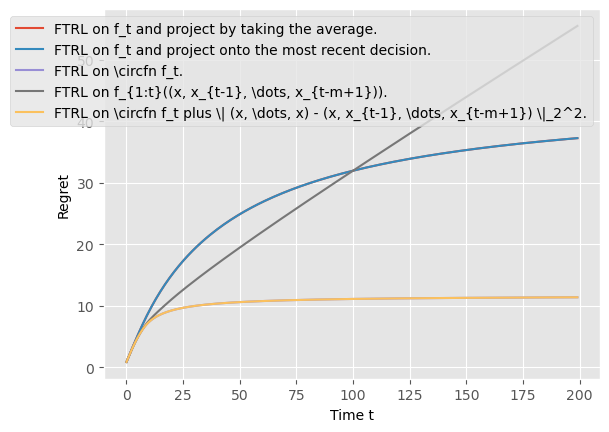

In [37]:
for (i, mode) in enumerate(algorithms.mode_strs):
    label = algorithms.mode_strs[mode]
    plt.plot(l_regret[i], label = label, alpha = l_alpha[i])
plt.xlabel('Time t')
plt.ylabel('Regret')
plt.legend()
plt.show()

### $\| h_t - (x_t, \dots, x_t) \|$.

In [38]:
l_diffs = []
for (i, mode) in enumerate(algorithms.mode_strs):

    diffs = []

    for t in range(T):

        h_t = [0] * max(0, m - t - 1) + \
            [l_ftrl_res[i][s].x for s in range(max(0, t - m + 1), t + 1)]
        x_t_history = [l_ftrl_res[i][t].x] * len(h_t)
        diff = np.linalg.norm(
            np.array(h_t) - np.array(x_t_history)
        )
        
        diffs.append(diff)

    diffs = np.array(diffs)
    l_diffs.append(diffs)

In [39]:
for (i, mode) in enumerate(algorithms.mode_strs):
    logging.info(
        f'Sum of norm differences between histories for mode {mode}: {np.sum(l_diffs[i])}'
    )

10:43:03 AM 969779365.py:2 Sum of norm differences between histories for mode 0: 4.13836510679428
10:43:03 AM 969779365.py:2 Sum of norm differences between histories for mode 1: 4.138365160835069
10:43:03 AM 969779365.py:2 Sum of norm differences between histories for mode 2: 4.940671846763653
10:43:03 AM 969779365.py:2 Sum of norm differences between histories for mode 3: 2.589000378663183
10:43:03 AM 969779365.py:2 Sum of norm differences between histories for mode 4: 4.940671881435668


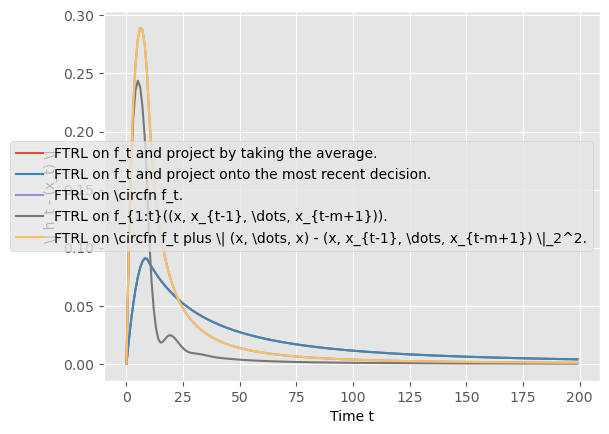

In [40]:
for (i, mode) in enumerate(algorithms.mode_strs):
    label = algorithms.mode_strs[mode]
    plt.plot(l_diffs[i], label = label, alpha = l_alpha[i])
plt.xlabel('Time t')
plt.ylabel('\| h_t - (x_t) \|')
plt.legend()
plt.show()

### $\| x_t^{(0)} - x_t^{(2)} \|$, where $x_t^{(i)}$ denotes the iterate in round $t$ produced by FTRL in mode $i$.

In [41]:
l_diff = [
    np.linalg.norm(l_ftrl_res[0][i].x - l_ftrl_res[2][i].x) \
        for i in range(T)
]

In [42]:
logging.info(
    f'Sum of norm differences between iterates for modes 0 and 2: {np.sum(l_diff)}'
)

10:43:04 AM 1198891545.py:1 Sum of norm differences between iterates for modes 0 and 2: 14.992374297038921


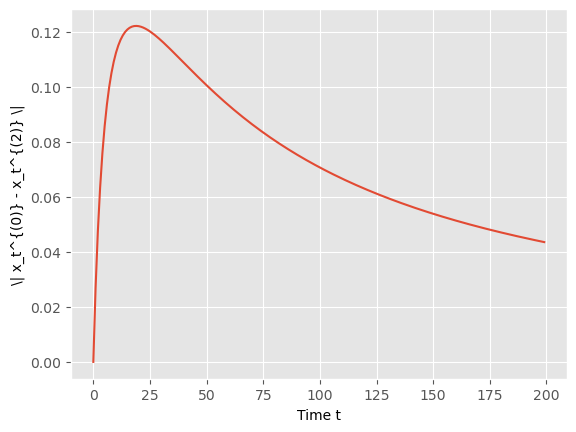

In [43]:
plt.plot(l_diff)
plt.xlabel('Time t')
plt.ylabel('\| x_t^{(0)} - x_t^{(2)} \|')
plt.show()

In [44]:
logging.info(f'Decisions for mode 0: {[res.x for res in l_ftrl_res[0][:]]}')
logging.info(f'Decisions for mode 2: {[res.x for res in l_ftrl_res[2][:]]}')

10:43:04 AM 3614189879.py:1 Decisions for mode 0: [-3.778955922986213e-09, 0.006561479947242957, 0.012842087381894093, 0.018859475203433528, 0.024629849643626696, 0.030168115839846084, 0.035488001657305326, 0.04060217539712267, 0.04552234230492687, 0.05025933488384684, 0.05482319438417096, 0.059223246707817576, 0.0634681523563223, 0.06756597195400066, 0.07152422575182373, 0.07534992094382321, 0.0790496083935426, 0.08262941165199024, 0.08609506587448568, 0.08945194651426461, 0.09270509002217531, 0.09585923959026713, 0.09891884085204614, 0.10188808226662371, 0.10477091155195746, 0.10757104750020392, 0.110291990889651, 0.1129370631361654, 0.11550937962124644, 0.1180119319910167, 0.12044748673467207, 0.12281870430117421, 0.12512812206131785, 0.12737810887580608, 0.12957092867606007, 0.13170874316054168, 0.13379357890470397, 0.13582739600403262, 0.13781204327642854, 0.13974928051939858, 0.14164078216205636, 0.14348815625621109, 0.14529292435246557, 0.14705653602717556, 0.14878040070905554, 

### $\sum_{s=1}^t fcirc_t(x_t^{(0)}) - fcirc_t(x_t^{(2)})$, where $x_t^{(i)}$ denotes the iterate in round $t$ produced by FTRL in mode $i$.

In [45]:
l_diff = [
    l_fn[i]([l_ftrl_res[0][i].x] * m) - l_fn[i]([l_ftrl_res[2][i].x] * m) \
        for i in range(T)
]
l_diff = np.cumsum(l_diff)

In [46]:
logging.info(
    f'Sum of norm differences between iterates for modes 0 and 2: {l_diff[-1]}'
)

10:43:04 AM 688310818.py:1 Sum of norm differences between iterates for modes 0 and 2: 25.98036749934431


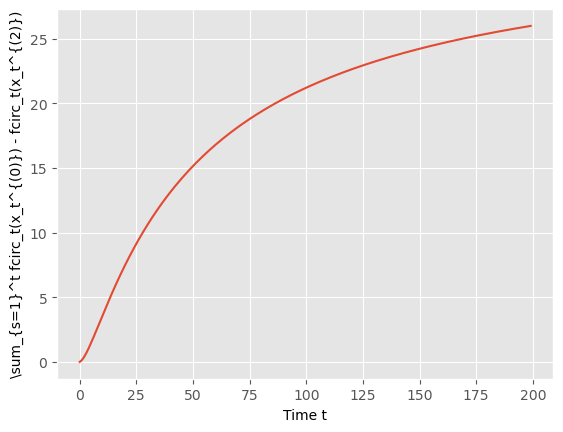

In [47]:
plt.plot(l_diff)
plt.xlabel('Time t')
plt.ylabel('\sum_{s=1}^t fcirc_t(x_t^{(0)}) - fcirc_t(x_t^{(2)})')
plt.show()

### Iterates.

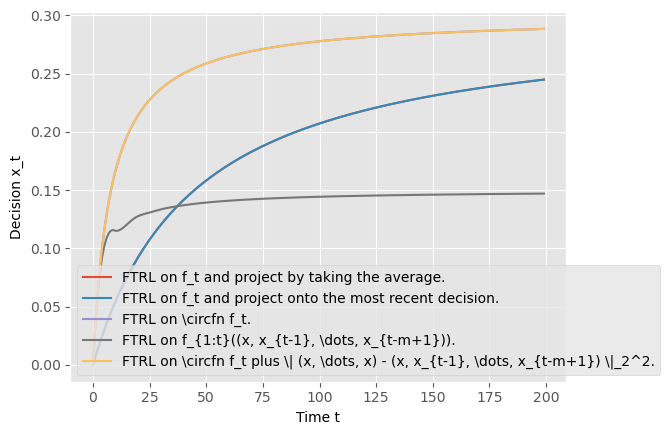

In [49]:
for (i, mode) in enumerate(algorithms.mode_strs):
    label = algorithms.mode_strs[mode]
    plt.plot([res.x for res in l_ftrl_res[i][:]], label = label, alpha = l_alpha[i])
plt.xlabel('Time t')
plt.ylabel('Decision x_t')
plt.legend()
plt.show()